<a href="https://colab.research.google.com/github/Pranjal3230/Kaggle-NLP-Disaster-Real-or-Not-with-Tensorflow2.x/blob/master/Copy_of_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2.1.0


     |████████████████████████████████| 421.8MB 39kB/s 
     |████████████████████████████████| 3.9MB 44.6MB/s 
     |████████████████████████████████| 450kB 43.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=384215076ec3ebebced63ded0d41ab087cc240ec019c6600f1b62bedff6f4cb9
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc

In [0]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow import keras
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from __future__ import absolute_import, division, print_function, unicode_literals
from keras.callbacks import TensorBoard
# Load the TensorBoard notebook extension
import datetime
import time

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import os

In [29]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:

!rm -rf ./logs/ 

In [0]:

df=pd.read_csv("train.csv")
df1=pd.read_csv("test.csv")

In [0]:
df3=pd.read_csv("sample_submission.csv")

In [33]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [34]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [35]:
df1.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [36]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


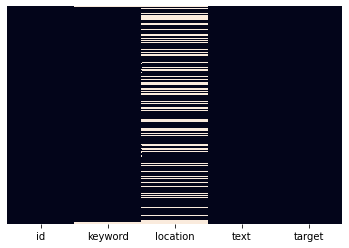

In [37]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False)

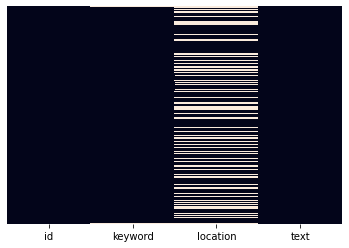

In [38]:
sns.heatmap(df1.isnull(),yticklabels=False,cbar=False)

In [39]:
df1.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [0]:
tr=df['text']
tr1=df1['text']

In [0]:
tar=df['target']

In [42]:
sent=[]
for sentence in tr:
  sent.append(sentence)
print(sent[0])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


In [43]:
sent1=[]
for sentence in tr1:
  sent1.append(sentence)
print(sent1[0])

Just happened a terrible car crash


In [44]:
label=[]
for sentence in tar:
  label.append(sentence)
print(label[0])

1


In [45]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sent)
vocab_size = len(tokenizer.word_counts)
print("vocabulary size: {:d}".format(vocab_size))
word2idx = tokenizer.word_index
idx2word = {v:k for (k, v) in word2idx.items()}

vocabulary size: 22700


In [46]:
seq_lengths = np.array([len(s.split()) for s in sent])
print([(p, np.percentile(seq_lengths, p)) for p
 in [75, 80, 90, 95, 99, 100]])

[(75, 19.0), (80, 20.0), (90, 22.0), (95, 24.0), (99, 27.0), (100, 31.0)]


In [0]:
max_seqlen = 31

sentences_as_ints = tokenizer.texts_to_sequences(sent)
sentences_as_ints = tf.keras.preprocessing.sequence.pad_sequences(
 sentences_as_ints, maxlen=max_seqlen)
labels_as_ints = np.array(label)

dataset = tf.data.Dataset.from_tensor_slices(
 (sentences_as_ints, labels_as_ints))


In [0]:
label1=[]
for i in range(len(sent1)):
  label1.append(0)

In [0]:

sentences_as_ints = tokenizer.texts_to_sequences(sent1)
sentences_as_ints = tf.keras.preprocessing.sequence.pad_sequences(
 sentences_as_ints, maxlen=max_seqlen)
labels_as_ints = np.array(label1)
dataset1 = tf.data.Dataset.from_tensor_slices(
 (sentences_as_ints, labels_as_ints))

In [50]:


dataset = dataset.shuffle(300)





test_size = len(sent) // 8
val_size = (len(sent)) // 6
test_dataset = dataset.take(test_size)
val_dataset = dataset.skip(test_size).take(val_size)
train_dataset = dataset.skip( test_size + val_size)
batch_size = 64
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
print(val_size)
print(len(sent))
print(test_size)

1268
7613
951


In [0]:
pred_dataset = dataset1.batch(batch_size)

In [64]:
class TextclassificationModel(tf.keras.Model):
  def __init__(self, vocab_size, max_seqlen, **kwargs):
    super(TextclassificationModel, self).__init__(**kwargs)
    self.embedding = tf.keras.layers.Embedding(
    vocab_size, max_seqlen)
    self.bilstm = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(max_seqlen)
    )
    
    self.dense = tf.keras.layers.Dense(64, activation="relu")
    
    self.out = tf.keras.layers.Dense(1, activation="sigmoid")
  def call(self, x):
    x = self.embedding(x)
    x = self.bilstm(x)
    x = self.dense(x)
    x= self.Dropout(x)
    x = self.out(x)
    return x
model = TextclassificationModel(vocab_size+1, max_seqlen)
model.build(input_shape=(batch_size, max_seqlen))
model.summary()
# compile
model.compile(
 loss="binary_crossentropy",
 optimizer="adam",
 metrics=["accuracy"]
)
data_dir = "./"
logs_dir = os.path.join("./logs")

best_model_file = os.path.join(data_dir, "best_model.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_model_file,
 save_weights_only=True,
 save_best_only=True)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)
num_epochs = 10
history = model.fit(train_dataset, epochs=num_epochs,
 validation_data=val_dataset,
 callbacks=[checkpoint, tensorboard])
model = TextclassificationModel(vocab_size+1, max_seqlen)
model.build(input_shape=(batch_size, max_seqlen))
model.summary()


Model: "textclassification_model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     multiple                  703731    
_________________________________________________________________
bidirectional_14 (Bidirectio multiple                  15624     
_________________________________________________________________
dense_22 (Dense)             multiple                  4032      
_________________________________________________________________
dropout_8 (Dropout)          multiple                  0         
_________________________________________________________________
dense_23 (Dense)             multiple                  65        
Total params: 723,452
Trainable params: 723,452
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
85/85 [==============================] - 4s 43ms/step - loss: 0.6368 - accuracy: 0.6199 

In [0]:
best_model = TextclassificationModel(vocab_size+1, max_seqlen)
best_model.build(input_shape=(batch_size, max_seqlen))
best_model.load_weights(best_model_file)
best_model.compile(
 loss="binary_crossentropy",
 optimizer="adam",
 metrics=["accuracy"]
)

In [66]:
test_loss, test_acc = best_model.evaluate(test_dataset)
print("test loss: {:.3f}, test accuracy: {:.3f}".format(
 test_loss, test_acc))

15/15 [==============================] - 0s 6ms/step - loss: 0.5297 - accuracy: 0.7434
test loss: 0.530, test accuracy: 0.743


In [0]:
pred=best_model.predict(pred_dataset)

In [0]:
g=[]
for n in pred:
  if n>0.5:
     g.append([1])

  else:
    g.append([0])
 
 

print("p", g)


prediction=pd.DataFrame(g)

p [[1], [0], [1], [0], [1], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [1], [0], [1], [0], [0], [0], [1], [0], [1], [0], [0], [1], [0], [0], [0], [0], [1], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [1], [0], [1], [1], [1], [1], [0], [1], [1], [1], [0], [0], [1], [1], [1], [1], [0], [0], [0], [1], [0], [0], [0], [1], [1], [1], [0], [0], [1], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [1], [1], [0], [0], [0], [1], [1], [0], [1], [1], [0], [1], [1], [1], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [1], [1], [1], [1], [0], [1], [0], [0], [1], [0], [0], [1], [1], [0], [1], [0], [0], [0], [1], [0], [0], [0], [1], [0], [1], [0], [1], [0], [0], [0], [1], [0], [0], [1

In [0]:
df3.pop('target')

0       0
1       0
2       0
3       0
4       0
       ..
3258    0
3259    0
3260    0
3261    0
3262    0
Name: target, Length: 3263, dtype: int64

In [0]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
dtypes: int64(1)
memory usage: 25.6 KB


In [0]:
df3=pd.concat([df3['id'],prediction],axis=1)

In [0]:
df3.columns=['id','target']

In [0]:
df3.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


In [0]:
df3.to_csv('f5text_classification_submission.csv',index=False)